In [39]:
import torch
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import pil_to_tensor
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from timeit import default_timer as timer
from PIL import Image
import random
from tqdm.auto import tqdm
import torchinfo
from torchinfo import summary
import os
import cv2
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%config InlineBackend.figure_format = "svg"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.__version__)
print(torchvision.__version__)
print(f"Using device:{device}")
print(f"Using {torch.cuda.get_device_name()}")

2.1.2+cu118
0.16.2+cu118
Using device:cuda
Using NVIDIA GeForce GTX 1650 Ti


In [40]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.startswith('image_') and file.endswith('.jpg')]
        self.mask_files = [file for file in os.listdir(root_dir) if file.startswith('label_') and file.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = img_name.replace('image_', 'label_').replace('.jpg', '.png')
        img_path = os.path.join(self.root_dir, img_name)
        mask_path = os.path.join(self.root_dir, mask_name)
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale mask
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Define transformations for the images and masks
transform = transforms.Compose([
    # transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()            # Convert images to PyTorch tensors
])

# Create the custom train dataset
custom_dataset = CustomDataset(root_dir="CT_train", transform=transform)
train_size = int(0.8 * len(custom_dataset))  # 80% of the data for training
val_size = len(custom_dataset) - train_size  # Remaining 20% for validation
# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Print the number of samples in the train dataset
print("Number of samples in the train dataset:", len(train_dataset))
print("Number of samples in the validation dataset:", len(val_dataset))

Number of samples in the train dataset: 1507
Number of samples in the validation dataset: 377


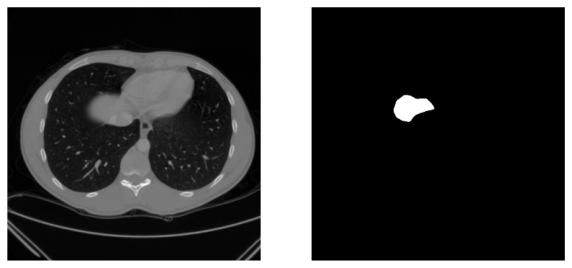

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [41]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
img,mask = train_dataset[random_idx]
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap = "gray")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "gray")
plt.axis(False)
plt.show()
img.shape, mask.shape

In [42]:
torch.unique(mask)

tensor([0., 1.])

In [43]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [44]:
class scSE(nn.Module):
    def __init__(self, in_channels, r = 2):
        super(scSE, self).__init__()
        mid_channels = in_channels//r
        self.cSE = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(mid_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Take mean over H and W dimensions
        mean_tensor = torch.mean(x, dim=[2, 3], keepdim=True)
        channel_scaling = self.cSE(mean_tensor).expand(-1, -1, x.size(2), x.size(3))
        u_cSE = x*channel_scaling
        spatial_scaling = self.sSE(x).expand(-1, x.size(1), -1, -1)
        u_sSE = x*spatial_scaling
        return torch.maximum(u_sSE,u_cSE)

In [45]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        # self.SE1 = scSE(16)
        # self.SE2 = scSE(32)
        # self.SE3 = scSE(64)
        # self.SE4 = scSE(128)
        # self.SE5 = scSE(64)
        # self.SE6 = scSE(32)
        # self.SE7 = scSE(16)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        # x1 = self.SE1(self.inc(x))
        # x2 = self.SE2(self.down1(x1))
        # x3 = self.SE3(self.down2(x2))
        # x4 = self.SE4(self.down3(x3))
        # x5 = self.down4(x4)
        # x = self.SE5(self.up1(x5, x4))
        # x = self.SE6(self.up2(x, x3))
        # x = self.SE7(self.up3(x, x2))

        x1 = (self.inc(x))
        x2 = (self.down1(x1))
        x3 = (self.down2(x2))
        x4 = (self.down3(x3))
        x5 = self.down4(x4)
        x = (self.up1(x5, x4))
        x = (self.up2(x, x3))
        x = (self.up3(x, x2))
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [46]:
class SEUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SEUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.SE1 = scSE(16)
        self.SE2 = scSE(32)
        self.SE3 = scSE(64)
        self.SE4 = scSE(128)
        self.SE5 = scSE(64)
        self.SE6 = scSE(32)
        self.SE7 = scSE(16)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        x1 = self.SE1(self.inc(x))
        x2 = self.SE2(self.down1(x1))
        x3 = self.SE3(self.down2(x2))
        x4 = self.SE4(self.down3(x3))
        x5 = self.down4(x4)
        x = self.SE5(self.up1(x5, x4))
        x = self.SE6(self.up2(x, x3))
        x = self.SE7(self.up3(x, x2))

        # x1 = (self.inc(x))
        # x2 = (self.down1(x1))
        # x3 = (self.down2(x2))
        # x4 = (self.down3(x3))
        # x5 = self.down4(x4)
        # x = (self.up1(x5, x4))
        # x = (self.up2(x, x3))
        # x = (self.up3(x, x2))
        
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [47]:
n_channels = 1
n_classes = 2
model = SEUNet(n_channels,n_classes,bilinear = True).to(device)
summary(model, input_size = [8,1,512,512])

Layer (type:depth-idx)                        Output Shape              Param #
SEUNet                                        [8, 2, 512, 512]          --
├─DoubleConv: 1-1                             [8, 16, 512, 512]         --
│    └─Sequential: 2-1                        [8, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [8, 16, 512, 512]         160
│    │    └─BatchNorm2d: 3-2                  [8, 16, 512, 512]         32
│    │    └─ReLU: 3-3                         [8, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [8, 16, 512, 512]         2,320
│    │    └─BatchNorm2d: 3-5                  [8, 16, 512, 512]         32
│    │    └─ReLU: 3-6                         [8, 16, 512, 512]         --
├─scSE: 1-2                                   [8, 16, 512, 512]         --
│    └─Sequential: 2-2                        [8, 16, 1, 1]             --
│    │    └─Conv2d: 3-7                       [8, 8, 1, 1]              136
│    │    └─ReL

In [48]:
# def calculate_class_weights(dataset):
#     # Initialize counters for each class
#     class_counts = {0:0,1:0}
    
#     # Iterate through the dataset to count pixel occurrences
#     for _, labels in tqdm(dataset):
#         # Flatten the label tensor and count occurrences
#         unique, counts = torch.unique(labels, return_counts=True)
#         for i,value in enumerate(unique):
#             class_counts[value.item()] +=counts[i]
    
#     # Calculate inverse frequencies
#     class_freq = np.zeros((2,))
#     total = 0
#     for i in range(2):
#         class_freq[i] = class_counts[i]
#         total = total + class_counts[i]
        
#     class_weights = total/class_freq
#     class_weights = class_weights/torch.sum(class_weights)

#     return class_weights.float()

# # Example usage:
# class_weights = calculate_class_weights(train_dataset)
# print("Class Weights:", class_weights)
# class_weights = class_weights.to(device)
# class_weights

In [49]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, labels):
        # Reshape logits to [batch_size * height * width, num_classes]
        logits_flat = logits.permute(0, 2, 3, 1).contiguous().view(-1, logits.shape[1])
        
        # Reshape labels to [batch_size * height * width]
        labels_flat = labels.view(-1)

        # Calculate cross entropy loss
        if self.weight is not None:
            # Apply class weights if provided
            loss = F.cross_entropy(logits_flat, labels_flat, weight=self.weight)
        else:
            # Without class weights
            loss = F.cross_entropy(logits_flat, labels_flat)
        return loss

In [50]:
class CrossEntropyDiceLoss(nn.Module):
    def __init__(self, num_classes, weight_ce=None, smooth_dice=1.):
        super(CrossEntropyDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.weight_ce = weight_ce
        self.smooth_dice = smooth_dice

    def forward(self, logits, targets):
        # Reshape logits to [N*H*W, C] and targets to [N*H*W]
        logits = logits.permute(0, 2, 3, 1).contiguous().view(-1, self.num_classes)
        targets = targets.view(-1)

        # Cross-entropy loss
        ce_loss = F.cross_entropy(logits, targets, weight=self.weight_ce)

        # Reshape logits back to [N, H, W, C]
        logits = logits.view(-1, logits.size(-1)).view(logits.size(0), -1, logits.size(-1)).permute(0, 2, 1)

        # Dice loss
        probs = torch.softmax(logits, dim=1)
        dice_loss = 0.

        for class_idx in range(1, self.num_classes):  # Exclude background class
            class_probs = probs[:, class_idx]
            class_targets = (targets == class_idx).float()

            # Flatten probabilities and targets
            class_probs_flat = class_probs.view(-1)
            class_targets_flat = class_targets.view(-1)

            # Calculate intersection and union
            intersection = torch.sum(class_probs_flat * class_targets_flat)
            union = torch.sum(class_probs_flat) + torch.sum(class_targets_flat)

            # Calculate Dice coefficient
            dice_coefficient = (2. * intersection + self.smooth_dice) / (union + self.smooth_dice)

            # Add class Dice loss to the total loss
            dice_loss += 1. - dice_coefficient

        # Average over classes
        dice_loss /= (self.num_classes - 1)

        # Combine cross-entropy and Dice losses
        loss = ce_loss + dice_loss

        return loss

# # Example usage:
# logits = torch.randn(2, 4, 128, 128)  # Example logits (4 classes including background)
# targets = torch.randint(0, 4, (2, 128, 128))  # Example targets (multi-class masks)

# # Define class weights for cross-entropy (optional)
# class_weights = torch.tensor([0.5, 1.0, 1.0, 1.5])  # Example class weights

# # Create an instance of CrossEntropyDiceLoss
# loss_function = CrossEntropyDiceLoss(num_classes=4, weight_ce=class_weights)

# # Calculate loss
# loss = loss_function(logits, targets)

# print(loss.item())  # Print the calculated loss


In [51]:
n_channels = 1
n_classes = 2
model = SEUNet(n_channels,n_classes,bilinear = True).to(device)
class_weights = torch.tensor([0.1,0.9])
loss_fn = CrossEntropyDiceLoss(num_classes = n_classes,weight_ce = class_weights)
optimizer = torch.optim.Adam(model.parameters())

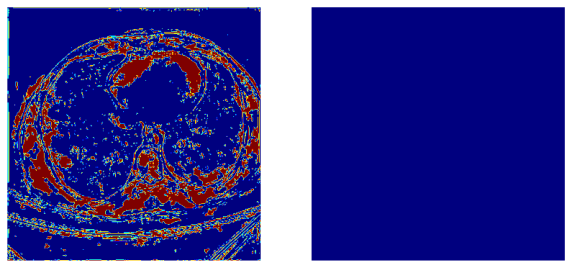

torch.Size([512, 512])

In [52]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
image,mask = train_dataset[random_idx]
image = image.to(device)
pred = model(image.unsqueeze(dim = 0)).squeeze()
labels = pred.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(labels.cpu(), cmap = "jet")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "jet")
plt.axis(False)
plt.show()
labels.shape

In [53]:
def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [54]:
n_channels = 1
n_classes = 2
model = SEUNet(n_channels,n_classes,bilinear = True).to(device)
model = nn.DataParallel(model)
class_weights = torch.tensor([0.1,0.9]).to(device)
loss_fn = CrossEntropyDiceLoss(num_classes = n_classes,weight_ce = class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma = 0.5)

In [55]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

initialize_weights(model)

In [56]:
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
len(train_dataloader), len(val_dataloader)

(75, 18)

In [19]:
num_epochs = 20
train_start = timer()
train_loss_vec = []
val_loss_vec = []
epoch_vec = []
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch}\n-----------")
    model.train()
    train_loss = 0
    for i,(img,mask) in enumerate(train_dataloader):
        if i%10 == 0:
            print(f"Train Mini-batch {i}")
        img,mask = img.to(device), mask.long().to(device)
        pred = model(img)
        loss = loss_fn(pred,mask.squeeze())
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss/=len(train_dataloader)
    train_loss_vec.append(train_loss.detach().cpu())
    epoch_vec.append(epoch)
    
    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for i,(val_img, val_mask) in enumerate(val_dataloader):
            if i%10==0:
                print(f"Validation Mini-batch {i}")
            val_img,val_mask = val_img.to(device), val_mask.long().to(device)
            val_pred = model(val_img)
            val_loss_step = loss_fn(val_pred,val_mask.squeeze())
            val_loss += val_loss_step
                
        val_loss/=len(val_dataloader)
        val_loss_vec.append(val_loss.cpu())

    scheduler.step()
    print(f"Training Loss = {train_loss:.4f} | Validation Loss = {val_loss:.4f}")

train_stop = timer()
time_taken = print_train_time(train_start, train_stop, device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Validation Mini-batch 10
Training Loss = 0.7411 | Validation Loss = 1.0513
Epoch 1
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Validation Mini-batch 10
Training Loss = 0.5342 | Validation Loss = 0.6662
Epoch 2
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Validation Mini-batch 10
Training Loss = 0.3694 | Validation Loss = 0.2971
Epoch 3
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train M

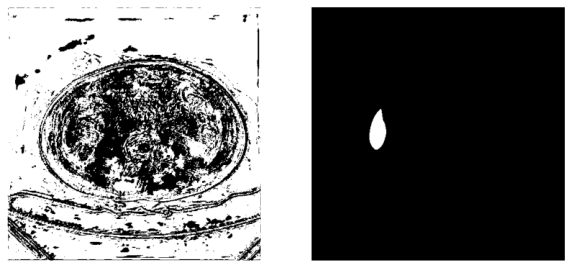

torch.Size([512, 512])

In [57]:
random_idx = torch.randint(0, len(val_dataset), size = [1,]).item()
image,mask = val_dataset[random_idx]
image = image.to(device)
pred = model(image.unsqueeze(dim = 0)).squeeze()
labels = pred.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(labels.cpu(), cmap = "gray")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "gray")
plt.axis(False)
plt.show()
labels.shape

In [58]:
def print_loss_curves(train_loss_vec,val_loss_vec,epoch_vec):
    plt.figure()
    plt.plot(train_loss_vec,label = "training loss")
    plt.plot(val_loss_vec,label = "validation loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [59]:
print_loss_curves(train_loss_vec,val_loss_vec,epoch_vec)

NameError: name 'train_loss_vec' is not defined

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)
MODEL_NAME = "second_unet.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
#torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [ ]:
se_model = SEUNet(n_channels = 1,n_classes = 2,bilinear = True).to(device)
se_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

In [ ]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
image,mask = train_dataset[random_idx]
image = image.to(device)
pred = se_model(image.unsqueeze(dim = 0)).squeeze()
labels = pred.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(labels.cpu(), cmap = "jet")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "jet")
plt.axis(False)
plt.show()
labels.shape

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)
MODEL_NAME = "first_unet.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [60]:
non_se_model = UNet(n_channels,n_classes,bilinear = True).to(device)
non_se_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [61]:
def jaccard_coefficient(prediction, target, class_index):
    smooth = 1e-7
    prediction = prediction == class_index
    target = target == class_index

    intersection = torch.sum(prediction & target).item()
    union = torch.sum(prediction | target).item()

    jaccard_score = (intersection + smooth) / (union + smooth)
    return jaccard_score

def compute_average_jaccard_coefficient(model, dataset, num_classes):
    model.eval()
    class_jaccard_scores = np.zeros(num_classes)
    with torch.inference_mode():
        for inputs, targets in tqdm(dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.unsqueeze(0)).squeeze().argmax(dim = 0)

            for class_index in range(num_classes):
                class_jaccard_scores[class_index] += jaccard_coefficient(outputs, targets, class_index)

    average_jaccard_scores = class_jaccard_scores / len(dataset)
    return average_jaccard_scores

In [62]:
num_classes = 2
se_jaccard_scores = compute_average_jaccard_coefficient(se_model, val_dataset, num_classes)
print(se_jaccard_scores)
se_jaccard_avg = np.mean(se_jaccard_scores[1:])
print(se_jaccard_avg)

  0%|          | 0/377 [00:00<?, ?it/s]

[0.9962872  0.86807959]
0.8680795936041039


In [63]:
num_classes = 2
non_se_jaccard_scores = compute_average_jaccard_coefficient(non_se_model, val_dataset, num_classes)
print(non_se_jaccard_scores)
non_se_jaccard_avg = np.mean(non_se_jaccard_scores[1:])
print(non_se_jaccard_avg)

  0%|          | 0/377 [00:00<?, ?it/s]

[0.99459962 0.79336236]
0.7933623616966103


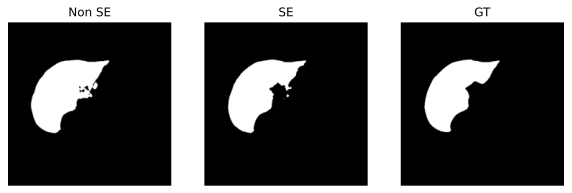

torch.Size([512, 512])

In [164]:
random_idx = torch.randint(0, len(val_dataset), size = [1,]).item()
image,mask = val_dataset[random_idx]
image = image.to(device)
pred_non_se = non_se_model(image.unsqueeze(dim = 0)).squeeze()
pred_se = se_model(image.unsqueeze(dim = 0)).squeeze()
labels_non_se = pred_non_se.squeeze().argmax(dim = 0).detach()
labels_se = pred_se.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(labels_non_se.cpu(), cmap = "gray")
plt.title("Non SE")
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(labels_se.cpu(), cmap = "gray")
plt.title("SE")
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap = "gray")
plt.title("GT")
plt.axis(False)
plt.show()
labels.shape